# Calculating embeddings, vectors and sentiment based on the data

## Install the relevant packages

In [ ]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


## Importing modules

In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
nltk.download('stopwords')

import gensim.downloader as api

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

import torch

import pickle

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data

In [ ]:
news_df = pd.read_csv('bloomberg_news_and_tickers_2022_V2.csv')

#sample data into n, only necessary when computing power not sufficient
#NEWS_DF = NEWS_DF.head(n=20000)

print(len(news_df))
news_df.head(10)

28764


,headline,ticker,date
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03
5,ESG Top Themes in U.S. for Jan. 28,TSLA US,2022-01-03
6,"Daimler ,GM Lead Carbon Transition for Non -El...",TSLA US,2022-01-03
7,"Facebook ,Google Digital -Ad Sales Can Bear FT...",AMZN US,2022-01-03
8,Materials Stocks Drive Earnings Misses for S &...,AAPL US,2022-01-03
9,Google Acquiring Cyber Startup Siemplify for $...,GOOGL US,2022-01-03


### Preprocessing

#### Check for dublicates

In [ ]:
news_df.drop_duplicates(subset=['headline', 'ticker', 'date'], inplace=True)
len(news_df)
 
# No dublicates

28764

#### Tokenization, Lower-casing, stop-word removal, etc.

In [ ]:
news_df['headline_tokens'] = news_df['headline'].apply(word_tokenize)

news_df['headline_tokens'] = news_df['headline_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

stop_words = set(stopwords.words('english'))
news_df['headline_tokens'] = news_df['headline_tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

news_df['headline_tokens'] = news_df['headline_tokens'].apply(lambda tokens: [token for token in tokens if token not in punctuation])

news_df.head(20)

,headline,ticker,date,headline_tokens
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet..."
5,ESG Top Themes in U.S. for Jan. 28,TSLA US,2022-01-03,"[esg, top, themes, u.s., jan., 28]"
6,"Daimler ,GM Lead Carbon Transition for Non -El...",TSLA US,2022-01-03,"[daimler, gm, lead, carbon, transition, non, -..."
7,"Facebook ,Google Digital -Ad Sales Can Bear FT...",AMZN US,2022-01-03,"[facebook, google, digital, -ad, sales, bear, ..."
8,Materials Stocks Drive Earnings Misses for S &...,AAPL US,2022-01-03,"[materials, stocks, drive, earnings, misses, p..."
9,Google Acquiring Cyber Startup Siemplify for $...,GOOGL US,2022-01-03,"[google, acquiring, cyber, startup, siemplify,..."


## Word2Vec

### Loading pre-trained word2vec model from Google and calculating the embeddings for each row

In [ ]:
# Load the pre-trained model
# Code inspired by this notebook https://colab.research.google.com/github/practical-nlp/practical-nlp/blob/master/Ch3/05_Pre_Trained_Word_Embeddings.ipynb?authuser=1#scrollTo=G1Or5oG5oPn1
model = api.load('word2vec-google-news-300')


In [ ]:
news_df['W2V_embedding'] = news_df['headline_tokens'].apply(lambda tokens: np.mean([model[token] for token in tokens if token in model], axis=0))
news_df

/anaconda/envs/jupyter_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,headline,ticker,date,headline_tokens,W2V_embedding
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0..."
...,...,...,...,...,...
28759,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066..."
28760,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869..."
28761,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122..."
28762,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073..."


### Checkpoint 0

In [ ]:
with open('checkpoint0.pickle', 'wb') as f:
    pickle.dump(news_df, f)

In [ ]:
with open('checkpoint0.pickle', 'rb') as f:
   news_df = pickle.load(f)


### Checking for NaN values and droping them

In [ ]:
contains_nan = news_df.isna().any().any() 
contains_nan

True

In [ ]:
def has_nan(arr):
        return np.isnan(np.sum(arr))

nan_indices = news_df.index[news_df["W2V_embedding"].apply(has_nan)]

# 'nan_indices' contains the row indices where NaN values are present
print(nan_indices)

print(news_df['W2V_embedding'].iloc[[1942, 6371, 19199]])

Index([1942, 6371, 19199], dtype='int64')
1942     NaN
6371     NaN
19199    NaN
Name: W2V_embedding, dtype: object


In [ ]:
news_df = news_df.drop([1942, 6371, 19199])
news_df = news_df.reset_index(drop = True)
news_df

,headline,ticker,date,headline_tokens,W2V_embedding
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0..."
...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066..."
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869..."
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122..."
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073..."


### Grouping the embeddings by date

In [ ]:
W2V_news = news_df.groupby('date')['W2V_embedding'].apply(list).reset_index(name='W2V_embedding')

# Turn list into arrays to apply methods easier
#W2V_news['W2V_embedding'] = W2V_news['W2V_embedding'].apply(lambda lst: np.array(lst))
W2V_news

# Now we have an dataframe that contains for each date the embeddings of all the news headlines of that date.
# The news headlines embeddings are the average of all word embeddings contained in that news headline.

,date,W2V_embedding
0,2022-01-03,"[[-0.040492468, 0.025495257, 0.015590123, 0.03..."
1,2022-01-04,"[[-0.035909016, -0.027028402, 0.07242838, -0.1..."
2,2022-01-05,"[[0.01961263, -0.065836586, -0.06077067, -0.04..."
3,2022-01-06,"[[0.09759903, -0.040145874, -0.08711624, 0.068..."
4,2022-01-07,"[[-0.106584825, 0.020507812, 0.16671316, 0.023..."
...,...,...
319,2022-12-27,"[[0.046142578, 0.082373045, -0.012402344, 0.00..."
320,2022-12-28,"[[0.02345058, 0.0063040596, -0.09735979, 0.048..."
321,2022-12-29,"[[-0.07890974, -0.0066353935, -0.0045166016, 0..."
322,2022-12-30,"[[-0.0043422156, -0.02432687, 0.068115234, 0.0..."


### Averaging by mean

In [ ]:
W2V_news['W2V_embedding_mean'] = W2V_news['W2V_embedding'].apply(lambda x: np.mean(x, axis=0))

W2V_news

#W2V_news.to_csv('word2vec_embeddings.csv', index=False)

,date,W2V_embedding,W2V_embedding_mean
0,2022-01-03,"[[-0.040492468, 0.025495257, 0.015590123, 0.03...","[0.003947516, 0.022911424, 0.0047796248, 0.072..."
1,2022-01-04,"[[-0.035909016, -0.027028402, 0.07242838, -0.1...","[0.011129712, 0.014293222, -0.012482789, 0.080..."
2,2022-01-05,"[[0.01961263, -0.065836586, -0.06077067, -0.04...","[-0.0053897635, 0.016805297, -0.01265114, 0.08..."
3,2022-01-06,"[[0.09759903, -0.040145874, -0.08711624, 0.068...","[-0.004168367, 0.0150124645, -0.008470944, 0.0..."
4,2022-01-07,"[[-0.106584825, 0.020507812, 0.16671316, 0.023...","[0.00022707936, 0.013337278, -0.011229015, 0.0..."
...,...,...,...
319,2022-12-27,"[[0.046142578, 0.082373045, -0.012402344, 0.00...","[-0.014258045, 0.03329225, 0.0010670747, 0.084..."
320,2022-12-28,"[[0.02345058, 0.0063040596, -0.09735979, 0.048...","[0.0060580317, 0.057908345, 0.0038581595, 0.07..."
321,2022-12-29,"[[-0.07890974, -0.0066353935, -0.0045166016, 0...","[0.00018076447, 0.041876163, 0.008176151, 0.05..."
322,2022-12-30,"[[-0.0043422156, -0.02432687, 0.068115234, 0.0...","[0.008708918, 0.042326655, 0.00464873, 0.06087..."


## Sentiment FinBERT

In [ ]:
news_df

,headline,ticker,date,headline_tokens,W2V_embedding
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0..."
...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066..."
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869..."
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122..."
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073..."


In [ ]:
# Code adapted from https://wandb.ai/ivangoncharov/FinBERT_Sentiment_Analysis_Project/reports/Financial-Sentiment-Analysis-on-Stock-Market-Headlines-With-FinBERT-HuggingFace--VmlldzoxMDQ4NjM0

In [ ]:
# Converting to list, as BERT needs a list as input
news_array = np.array(news_df)
news_list = list(news_array[:,0])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
inputs = tokenizer(news_list, padding = True, truncation = True, return_tensors='pt')
print(inputs)


{'input_ids': tensor([[  101,  6207, 12154,  ...,     0,     0,     0],
        [  101,  1008,  7513,  ...,     0,     0,     0],
        [  101,  6300, 14277,  ...,     0,     0,     0],
        ...,
        [  101,  5199,  5660,  ...,     0,     0,     0],
        [  101, 22625,  8619,  ...,     0,     0,     0],
        [  101,  1049,  1004,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
with torch.no_grad():
    outputs = model(**inputs)
print(outputs.logits.shape)

torch.Size([28761, 3])


In [ ]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)


tensor([[0.2790, 0.6612, 0.0598],
        [0.0772, 0.0194, 0.9034],
        [0.0202, 0.3722, 0.6076],
        ...,
        [0.0744, 0.0414, 0.8842],
        [0.4065, 0.0305, 0.5630],
        [0.0363, 0.6553, 0.3084]])


In [ ]:
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Headline':news_list,
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}
      
df = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])

df

,Headline,Positive,Negative,Neutral
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",0.278953,0.661236,0.059811
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,0.077194,0.019439,0.903367
2,Yelp Legal Chief Retires as Deputy Takes Over ...,0.020235,0.372197,0.607568
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",0.027186,0.942529,0.030286
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",0.110356,0.039804,0.849840
...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",0.789206,0.016759,0.194035
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",0.855071,0.018718,0.126211
28758,Tim Cook Discussed App Store Concern with Japa...,0.074418,0.041388,0.884194
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",0.406506,0.030494,0.563001


In [ ]:
max_column = df[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)

df['Max_Column'] = max_column

df

,Headline,Positive,Negative,Neutral,Max_Column
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",0.278953,0.661236,0.059811,Negative
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,0.077194,0.019439,0.903367,Neutral
2,Yelp Legal Chief Retires as Deputy Takes Over ...,0.020235,0.372197,0.607568,Neutral
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",0.027186,0.942529,0.030286,Negative
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",0.110356,0.039804,0.849840,Neutral
...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",0.789206,0.016759,0.194035,Positive
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",0.855071,0.018718,0.126211,Positive
28758,Tim Cook Discussed App Store Concern with Japa...,0.074418,0.041388,0.884194,Neutral
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",0.406506,0.030494,0.563001,Neutral


In [ ]:
df['sentiment'] = df['Max_Column'].apply(lambda x: 1 if x == 'Positive' else (-1 if x == 'Negative' else 0))
#print(len(df),len(news_df))
df


,Headline,Positive,Negative,Neutral,Max_Column,sentiment
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",0.278953,0.661236,0.059811,Negative,-1
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,0.077194,0.019439,0.903367,Neutral,0
2,Yelp Legal Chief Retires as Deputy Takes Over ...,0.020235,0.372197,0.607568,Neutral,0
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",0.027186,0.942529,0.030286,Negative,-1
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",0.110356,0.039804,0.849840,Neutral,0
...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",0.789206,0.016759,0.194035,Positive,1
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",0.855071,0.018718,0.126211,Positive,1
28758,Tim Cook Discussed App Store Concern with Japa...,0.074418,0.041388,0.884194,Neutral,0
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",0.406506,0.030494,0.563001,Neutral,0


In [ ]:
#nan_locations = np.where(df['Max_Column'].isna())[0]
#nan_locations


In [ ]:
news_df['sentiment'] = df['Max_Column']
news_df['sentiment score'] = df['sentiment']
news_df

,headline,ticker,date,headline_tokens,W2V_embedding,sentiment,sentiment score
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033...",Negative,-1
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691...",Neutral,0
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05...",Neutral,0
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261...",Negative,-1
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0...",Neutral,0
...,...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066...",Positive,1
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869...",Positive,1
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122...",Neutral,0
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073...",Neutral,0


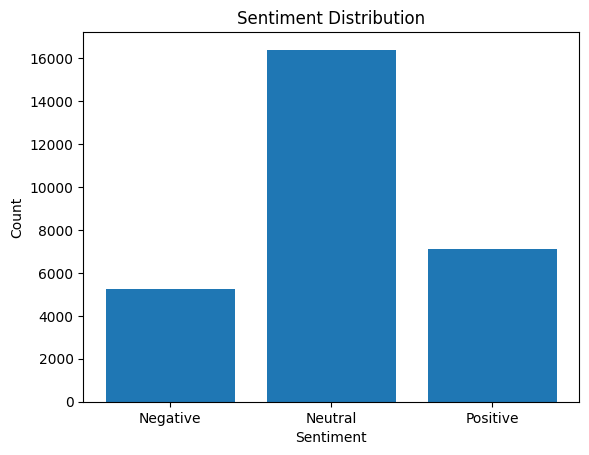

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentiment_distribution(df, column_name):
    sentiment_counts = df[column_name].value_counts()
    
    labels = ['Negative', 'Neutral', 'Positive']
    values = [sentiment_counts.get(-1, 0), sentiment_counts.get(0, 0), sentiment_counts.get(1, 0)]
    
    fig, ax = plt.subplots()
    ax.bar(labels, values)
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Count')
    ax.set_title('Sentiment Distribution')

    plt.show()


plot_sentiment_distribution(news_df, 'sentiment')

### Checkpoint 1
Saving Word2Vec, Sentiment

In [ ]:
with open('checkpoint1.pickle', 'wb') as f:
    pickle.dump(news_df, f)

In [ ]:
with open('checkpoint1.pickle', 'rb') as f:
   news_df = pickle.load(f)

news_df

,headline,ticker,date,headline_tokens,W2V_embedding,sentiment,sentiment score
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033...",Negative,-1
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691...",Neutral,0
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05...",Neutral,0
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261...",Negative,-1
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0...",Neutral,0
...,...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066...",Positive,1
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869...",Positive,1
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122...",Neutral,0
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073...",Neutral,0


## Word Embeddings BERT

In [ ]:

MODEL_NAME = 'distilbert-base-uncased'
N_ROWS = 1000 #number of rows to read from input file.

In [ ]:
bert_array = np.array(news_df)
bert_list = list(bert_array[:,0])
#print(bert_list)
len(bert_list)

28761

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model= AutoModel.from_pretrained(MODEL_NAME)



tokenized = tokenizer(bert_list, 
                      add_special_tokens= True, 
                      padding = 'longest',
                      return_attention_mask=True,
                      return_tensors='pt',
                      verbose = True) # Note: BERT expects a list of strings as input

print(tokenized)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'input_ids': tensor([[  101,  6207, 12154,  ...,     0,     0,     0],
        [  101,  1008,  7513,  ...,     0,     0,     0],
        [  101,  6300, 14277,  ...,     0,     0,     0],
        ...,
        [  101,  5199,  5660,  ...,     0,     0,     0],
        [  101, 22625,  8619,  ...,     0,     0,     0],
        [  101,  1049,  1004,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
# Adapted Code from LAB
def get_bert_embeddings(model, tokenized):

    """ Calculate BERT embeddings for a batch of sentences.
    NOTE: Calculating BERT embeddings is a very expensive operation.
    Particularly on CPU, it can take a long time to calculate embeddings for
    a large batch of sentences (Max 10-20 minutes for 6K sentences).

    Args:
        model (transformers BERT model): BERT model.
        tokenized (dict): Dictionary of tokenized sentences (input_ids and attention_mask)

    Returns:
        n-d NumPy array: BERT embeddings for the sentences in the batch.
    """

    print("Getting model encodings...")
    # The following is a context-manager that disables gradient calculation.
    # Disabling gradient calculation is useful for inference, when you are 
    # sure that you will not call Tensor.backward(). It will reduce memory 
    # consumption for computations that would otherwise have requires_grad=True.
    # TLDR: calculating gradients is expensive. We don't need them for inference.
    with torch.no_grad():
        last_hidden_states = model(**tokenized)

    # last_hidden_states[0] is the last hidden state of the first token of the
    # sequence (classification token) further processed by a Linear layer and 
    # a Tanh activation function. The Linear layer weights are trained from the
    # next sentence prediction (classification) objective during pretraining.
    # last_hidden_states[0].shape = (batch_size, hidden_size)
    print("Returning embeddings...")
    return last_hidden_states[0][:,0,:].numpy()

embeddings = get_bert_embeddings(model, tokenized)
embeddings.shape


Getting model encodings...
Returning embeddings...


(28761, 768)

In [ ]:
embeddings

array([[-0.3693831 , -0.2471672 , -0.00151839, ..., -0.39357156,
         0.28856337,  0.22414307],
       [-0.07237873,  0.00063813, -0.0087127 , ..., -0.29441005,
         0.35044098,  0.49016488],
       [-0.45018384, -0.01293638,  0.06695734, ..., -0.3798224 ,
         0.2727712 ,  0.12574874],
       ...,
       [-0.1387554 , -0.1150637 , -0.22877398, ..., -0.17233136,
         0.40109774,  0.19798513],
       [-0.22854273, -0.18196224,  0.0288381 , ..., -0.12949921,
         0.21028131,  0.3025534 ],
       [-0.26762316, -0.23236513, -0.20619598, ..., -0.02032498,
         0.21627825,  0.31722304]], dtype=float32)

In [ ]:
#with open('bert_embeddings_bloomberg', 'wb') as f:
#    pickle.dump(embeddings, f)
#    f.close()

In [ ]:
#with open('bert_embeddings_bloomberg', 'rb') as f:
#    embeddings = pickle.load(f)

In [ ]:
bert_embeddings_bloomberg= embeddings
bert_embeddings_bloomberg

array([[-0.3693831 , -0.2471672 , -0.00151839, ..., -0.39357156,
         0.28856337,  0.22414307],
       [-0.07237873,  0.00063813, -0.0087127 , ..., -0.29441005,
         0.35044098,  0.49016488],
       [-0.45018384, -0.01293638,  0.06695734, ..., -0.3798224 ,
         0.2727712 ,  0.12574874],
       ...,
       [-0.1387554 , -0.1150637 , -0.22877398, ..., -0.17233136,
         0.40109774,  0.19798513],
       [-0.22854273, -0.18196224,  0.0288381 , ..., -0.12949921,
         0.21028131,  0.3025534 ],
       [-0.26762316, -0.23236513, -0.20619598, ..., -0.02032498,
         0.21627825,  0.31722304]], dtype=float32)

### Adding BERT embeddings to news_df

In [ ]:
news_df['BERT embeddings'] = pd.Series(bert_embeddings_bloomberg.tolist())
news_df

,headline,ticker,date,headline_tokens,W2V_embedding,sentiment,sentiment score,BERT embeddings
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033...",Negative,-1,"[-0.3693830966949463, -0.2471671998500824, -0...."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691...",Neutral,0,"[-0.0723787322640419, 0.0006381346029229462, -..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05...",Neutral,0,"[-0.45018383860588074, -0.012936383485794067, ..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261...",Negative,-1,"[-0.503657341003418, 0.03226497024297714, 0.05..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0...",Neutral,0,"[-0.2243078202009201, -0.18984462320804596, 0...."
...,...,...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066...",Positive,1,"[-0.048444513231515884, -0.2091042399406433, 0..."
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869...",Positive,1,"[-0.3264872133731842, -0.18921507894992828, 0...."
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122...",Neutral,0,"[-0.13875539600849152, -0.11506370455026627, -..."
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073...",Neutral,0,"[-0.2285427302122116, -0.18196223676204681, 0...."


### Checkpoint 2
Save W2V, Sentiment, BERT

In [ ]:
# Saving
with open('checkpoint2.pickle', 'wb') as f:
    pickle.dump(news_df, f)

In [ ]:
# Loading
with open('checkpoint2.pickle', 'rb') as f:
    news_df = pickle.load(f)

## Bag of words model

### Count Vectorizer

In [ ]:
# Initialize the CountVectorizer with optional parameters
vectorizer = CountVectorizer(min_df=1, stop_words="english", lowercase=True)

vectorizer.fit(news_df['headline'])

#print("Vocabulary size: {}".format(len(vectorizer.vocabulary_))) 
#print("Vocabulary content:\n {}".format(vectorizer.vocabulary_))

CountVectorizer(stop_words='english')

In [ ]:
# Learn the vocabulary dictionary and return document-term matrix
X = vectorizer.fit_transform(news_df['headline'])

# SciPy sparse matrix (only stores entries that are nonzero)
print("X: {}".format(repr(X)))

X: <28761x18504 sparse matrix of type '<class 'numpy.int64'>'
	with 207137 stored elements in Compressed Sparse Row format>


In [ ]:
# Dense NumPy array
print("Dense representation of X:\n{}".format(X.toarray()))

Dense representation of X:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
news_df['bow'] = list(X.toarray())
news_df

,headline,ticker,date,headline_tokens,W2V_embedding,sentiment,sentiment score,BERT embeddings,bow
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033...",Negative,-1,"[-0.3693830966949463, -0.2471671998500824, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691...",Neutral,0,"[-0.0723787322640419, 0.0006381346029229462, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05...",Neutral,0,"[-0.45018383860588074, -0.012936383485794067, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261...",Negative,-1,"[-0.503657341003418, 0.03226497024297714, 0.05...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0...",Neutral,0,"[-0.2243078202009201, -0.18984462320804596, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066...",Positive,1,"[-0.048444513231515884, -0.2091042399406433, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869...",Positive,1,"[-0.3264872133731842, -0.18921507894992828, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122...",Neutral,0,"[-0.13875539600849152, -0.11506370455026627, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073...",Neutral,0,"[-0.2285427302122116, -0.18196223676204681, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Tfidf Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Create object of TfidfTransformer methos and do fit_transform
vectorizer_tfidf = TfidfTransformer(smooth_idf=True,norm=None)
X_tfidf = vectorizer_tfidf.fit_transform(X).toarray()

# Create a new column 'bow_tfidf' and store results 
news_df['bow_tfidf'] = list(X_tfidf)

In [ ]:
news_df

,headline,ticker,date,headline_tokens,W2V_embedding,sentiment,sentiment score,BERT embeddings,bow,bow_tfidf
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033...",Negative,-1,"[-0.3693830966949463, -0.2471671998500824, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691...",Neutral,0,"[-0.0723787322640419, 0.0006381346029229462, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05...",Neutral,0,"[-0.45018383860588074, -0.012936383485794067, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261...",Negative,-1,"[-0.503657341003418, 0.03226497024297714, 0.05...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0...",Neutral,0,"[-0.2243078202009201, -0.18984462320804596, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066...",Positive,1,"[-0.048444513231515884, -0.2091042399406433, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869...",Positive,1,"[-0.3264872133731842, -0.18921507894992828, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122...",Neutral,0,"[-0.13875539600849152, -0.11506370455026627, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073...",Neutral,0,"[-0.2285427302122116, -0.18196223676204681, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
value = news_df['bow_tfidf'][10]
non_zero_values = [x for x in value if x != 0]
print(non_zero_values)


[7.004130473405009, 5.228939430524187, 5.56971686394092, 7.032703845849065, 3.754739104610858, 5.859638578986206]


### Checkpoint 3
Save W2V, Sentiment, BERT, BoW

In [ ]:
with open('checkpoint3.pickle', 'wb') as f:
    pickle.dump(news_df, f)

## Averaging by mean for all embeddings


In [ ]:
news_df

,headline,ticker,date,headline_tokens,W2V_embedding,sentiment,sentiment score,BERT embeddings,bow,bow_tfidf
0,"Apple Gains After Overcoming Supply Crunch ,Tr...",AAPL US,2022-01-03,"[apple, gains, overcoming, supply, crunch, tro...","[-0.040492468, 0.025495257, 0.015590123, 0.033...",Negative,-1,"[-0.3693830966949463, -0.2471671998500824, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,*MICROSOFT SAYS DEAL TO BUY ACTIVISION IS ALL ...,MSFT US,2022-01-03,"[microsoft, says, deal, buy, activision, cash,...","[0.07501221, -0.00163923, -0.06940569, 0.08691...",Neutral,0,"[-0.0723787322640419, 0.0006381346029229462, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Yelp Legal Chief Retires as Deputy Takes Over ...,GOOGL US,2022-01-03,"[yelp, legal, chief, retires, deputy, takes, t...","[0.004204644, -0.03481886, -0.009033203, -0.05...",Neutral,0,"[-0.45018383860588074, -0.012936383485794067, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"Chipmakers Broadly Lower ,With Nvidia and AMD ...",AMD US,2022-01-03,"[chipmakers, broadly, lower, nvidia, amd, lead...","[-0.0625, -0.13540213, -0.012765067, 0.1971261...",Negative,-1,"[-0.503657341003418, 0.03226497024297714, 0.05...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"DNB Nordic Tech Exits NOS ,Buys More Alphabet ...",GOOGL US,2022-01-03,"[dnb, nordic, tech, exits, nos, buys, alphabet...","[-0.00086021423, 0.056728363, 0.037719727, 0.0...",Neutral,0,"[-0.2243078202009201, -0.18984462320804596, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...
28756,"*TESLA EXTENDS $7,500CREDIT TO MODEL S ,X IN U...",TSLA US,2022-12-31,"[tesla, extends, 7,500credit, model, x, us, sa...","[0.0054234094, 0.064453125, 0.044828143, 0.066...",Positive,1,"[-0.048444513231515884, -0.2091042399406433, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28757,"ClearBridge US Large Cap Growth Exits Disney ,...",NFLX US,2022-12-31,"[clearbridge, us, large, cap, growth, exits, d...","[-0.029052734, 0.0733163, -0.0773468, 0.108869...",Positive,1,"[-0.3264872133731842, -0.18921507894992828, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28758,Tim Cook Discussed App Store Concern with Japa...,AAPL US,2022-12-31,"[tim, cook, discussed, app, store, concern, ja...","[-0.11314562, 0.011135525, -0.012084961, 0.122...",Neutral,0,"[-0.13875539600849152, -0.11506370455026627, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28759,"Fidelity Advisor Tech Exits Flex ,Buys More Nv...",NVDA US,2022-12-31,"[fidelity, advisor, tech, exits, flex, buys, n...","[0.06816755, -0.071777344, -0.060895648, 0.073...",Neutral,0,"[-0.2285427302122116, -0.18196223676204681, 0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Grouping by date

In [ ]:
grouped1 = news_df.groupby('date')['W2V_embedding'].apply(list).reset_index(name='W2V embeddings')
# turn list into arrays to apply methods easier
grouped1['W2V embeddings'] = grouped1['W2V embeddings'].apply(lambda lst: np.array(lst, dtype = object))


grouped2 = news_df.groupby('date')['BERT embeddings'].apply(list).reset_index(name='BERT embeddings')

# turn list into arrays to apply methods easier
grouped2['BERT embeddings'] = grouped2['BERT embeddings'].apply(lambda lst: np.array(lst, dtype = object))

#sentiment score column
grouped3 = news_df.groupby('date')['sentiment score'].apply(list).reset_index(name='sentiment score')

# Bow column (grouping + adding the arrays)
grouped4 = news_df.groupby('date').agg({'bow': lambda x: np.sum(x, axis=0).tolist()})

# Bow with tfidf (grouping + adding the arrays))
grouped5 = news_df.groupby('date').agg({'bow_tfidf': lambda x: np.sum(x, axis=0).tolist()})


grouped1['BERT embeddings'] = grouped2['BERT embeddings']
grouped1['sentiment score'] = grouped3['sentiment score']
grouped = grouped1
grouped

,date,W2V embeddings,BERT embeddings,sentiment score
0,2022-01-03,"[[-0.0404924675822258, 0.0254952572286129, 0.0...","[[-0.3693830966949463, -0.2471671998500824, -0...","[-1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,2022-01-04,"[[-0.0359090156853199, -0.02702840231359005, 0...","[[-0.06224224716424942, -0.2979371249675751, 0...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, 1, 0, 0, 0,..."
2,2022-01-05,"[[0.01961263082921505, -0.0658365860581398, -0...","[[-0.10791551321744919, -0.1328592747449875, 0...","[1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 1, ..."
3,2022-01-06,"[[0.09759902954101562, -0.0401458740234375, -0...","[[-0.2522630989551544, -0.28231102228164673, 0...","[1, 1, 0, -1, 0, 1, 1, -1, -1, 0, 0, 0, 0, 0, ..."
4,2022-01-07,"[[-0.1065848246216774, 0.0205078125, 0.1667131...","[[-0.19235484302043915, -0.22265130281448364, ...","[0, -1, 1, 1, 1, 0, -1, 0, 0, -1, 0, 0, 1, -1,..."
...,...,...,...,...
319,2022-12-27,"[[0.046142578125, 0.08237304538488388, -0.0124...","[[-0.3981975317001343, -0.13455665111541748, 0...","[0, 0, 0, -1, -1, -1, -1, 0, -1, -1, 0, 0, -1,..."
320,2022-12-28,"[[0.0234505794942379, 0.0063040596432983875, -...","[[-0.23385146260261536, -0.23462671041488647, ...","[1, -1, 0, -1, 1, 0, 0, -1, 1, 0, 1, 0, 0, 0, ..."
321,2022-12-29,"[[-0.0789097398519516, -0.0066353934817016125,...","[[-0.27909645438194275, -0.10552593320608139, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1, 1, 1, 1,..."
322,2022-12-30,"[[-0.004342215601354837, -0.02432687021791935,...","[[0.01812063157558441, -0.2427556961774826, -0...","[0, 0, 0, 1, 0, 1, 0, 0, -1, 0, 0, -1, -1, 0, ..."


### Averaging

In [ ]:
grouped['BERT embeddings_mean'] = grouped['BERT embeddings'].apply(lambda x: np.mean(x, axis=0))
grouped['W2V embeddings_mean'] = grouped['W2V embeddings'].apply(lambda x: np.mean(x, axis=0))
grouped['average sentiment score'] = grouped['sentiment score'].apply(lambda x: np.mean(x, axis=0))
grouped['bag of words'] = grouped4['bow'].tolist()
grouped['bag of words_tfidf'] = grouped5['bow_tfidf'].tolist()

nlp_task_output = grouped
nlp_task_output


,date,W2V embeddings,BERT embeddings,sentiment score,BERT embeddings_mean,W2V embeddings_mean,average sentiment score,bag of words,bag of words_tfidf
0,2022-01-03,"[[-0.0404924675822258, 0.0254952572286129, 0.0...","[[-0.3693830966949463, -0.2471671998500824, -0...","[-1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[-0.228029658080175, -0.17713059568496678, 0.0...","[0.003947518421497581, 0.022911421280827952, 0...",-0.055172,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-01-04,"[[-0.0359090156853199, -0.02702840231359005, 0...","[[-0.06224224716424942, -0.2979371249675751, 0...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, 1, 0, 0, 0,...","[-0.230750181076185, -0.18562821314359704, -0....","[0.01112971006991054, 0.014293222201654946, -0...",-0.024390,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-01-05,"[[0.01961263082921505, -0.0658365860581398, -0...","[[-0.10791551321744919, -0.1328592747449875, 0...","[1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 1, ...","[-0.23156420670578773, -0.1829247910984611, -0...","[-0.005389764467115278, 0.01680529410577268, -...",0.052239,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-01-06,"[[0.09759902954101562, -0.0401458740234375, -0...","[[-0.2522630989551544, -0.28231102228164673, 0...","[1, 1, 0, -1, 0, 1, 1, -1, -1, 0, 0, 0, 0, 0, ...","[-0.23953293037640166, -0.1844954190851176, -0...","[-0.004168366527998112, 0.015012458536378764, ...",0.140845,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-01-07,"[[-0.1065848246216774, 0.0205078125, 0.1667131...","[[-0.19235484302043915, -0.22265130281448364, ...","[0, -1, 1, 1, 1, 0, -1, 0, 0, -1, 0, 0, 1, -1,...","[-0.22612745273240412, -0.17468479186153182, -...","[0.00022708027659413906, 0.013337278338999918,...",-0.038462,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
319,2022-12-27,"[[0.046142578125, 0.08237304538488388, -0.0124...","[[-0.3981975317001343, -0.13455665111541748, 0...","[0, 0, 0, -1, -1, -1, -1, 0, -1, -1, 0, 0, -1,...","[-0.26531250585188587, -0.1853176990251352, 0....","[-0.014258044573092243, 0.03329225022345071, 0...",-0.195122,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
320,2022-12-28,"[[0.0234505794942379, 0.0063040596432983875, -...","[[-0.23385146260261536, -0.23462671041488647, ...","[1, -1, 0, -1, 1, 0, 0, -1, 1, 0, 1, 0, 0, 0, ...","[-0.24873552998070847, -0.18875928787100646, 0...","[0.006058031684477572, 0.05790834233199281, 0....",0.037037,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
321,2022-12-29,"[[-0.0789097398519516, -0.0066353934817016125,...","[[-0.27909645438194275, -0.10552593320608139, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1, 1, 1, 1,...","[-0.24983371656708186, -0.1996163552366852, 0....","[0.00018076455796744995, 0.041876158331433544,...",0.078125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
322,2022-12-30,"[[-0.004342215601354837, -0.02432687021791935,...","[[0.01812063157558441, -0.2427556961774826, -0...","[0, 0, 0, 1, 0, 1, 0, 0, -1, 0, 0, -1, -1, 0, ...","[-0.24502491698201215, -0.14490794693535594, -...","[0.008708919138630986, 0.04232665225364534, 0....",-0.053571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Final Output

In [ ]:
with open('nlp_task_output.pickle', 'wb') as f:
    pickle.dump(nlp_task_output, f)


In [ ]:
#with open('nlp_task_output.pickle', 'rb') as f:
#    nlp_task_output = pickle.load(f)

In [ ]:
nlp_task_output

,date,W2V embeddings,BERT embeddings,sentiment score,BERT embeddings_mean,W2V embeddings_mean,average sentiment score,bag of words,bag of words_tfidf
0,2022-01-03,"[[-0.0404924675822258, 0.0254952572286129, 0.0...","[[-0.3693830966949463, -0.2471671998500824, -0...","[-1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[-0.228029658080175, -0.17713059568496678, 0.0...","[0.003947518421497581, 0.022911421280827952, 0...",-0.055172,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-01-04,"[[-0.0359090156853199, -0.02702840231359005, 0...","[[-0.06224224716424942, -0.2979371249675751, 0...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, 1, 0, 0, 0,...","[-0.230750181076185, -0.18562821314359704, -0....","[0.01112971006991054, 0.014293222201654946, -0...",-0.024390,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2022-01-05,"[[0.01961263082921505, -0.0658365860581398, -0...","[[-0.10791551321744919, -0.1328592747449875, 0...","[1, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 1, ...","[-0.23156420670578773, -0.1829247910984611, -0...","[-0.005389764467115278, 0.01680529410577268, -...",0.052239,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2022-01-06,"[[0.09759902954101562, -0.0401458740234375, -0...","[[-0.2522630989551544, -0.28231102228164673, 0...","[1, 1, 0, -1, 0, 1, 1, -1, -1, 0, 0, 0, 0, 0, ...","[-0.23953293037640166, -0.1844954190851176, -0...","[-0.004168366527998112, 0.015012458536378764, ...",0.140845,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2022-01-07,"[[-0.1065848246216774, 0.0205078125, 0.1667131...","[[-0.19235484302043915, -0.22265130281448364, ...","[0, -1, 1, 1, 1, 0, -1, 0, 0, -1, 0, 0, 1, -1,...","[-0.22612745273240412, -0.17468479186153182, -...","[0.00022708027659413906, 0.013337278338999918,...",-0.038462,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
319,2022-12-27,"[[0.046142578125, 0.08237304538488388, -0.0124...","[[-0.3981975317001343, -0.13455665111541748, 0...","[0, 0, 0, -1, -1, -1, -1, 0, -1, -1, 0, 0, -1,...","[-0.26531250585188587, -0.1853176990251352, 0....","[-0.014258044573092243, 0.03329225022345071, 0...",-0.195122,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
320,2022-12-28,"[[0.0234505794942379, 0.0063040596432983875, -...","[[-0.23385146260261536, -0.23462671041488647, ...","[1, -1, 0, -1, 1, 0, 0, -1, 1, 0, 1, 0, 0, 0, ...","[-0.24873552998070847, -0.18875928787100646, 0...","[0.006058031684477572, 0.05790834233199281, 0....",0.037037,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
321,2022-12-29,"[[-0.0789097398519516, -0.0066353934817016125,...","[[-0.27909645438194275, -0.10552593320608139, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1, 1, 1, 1,...","[-0.24983371656708186, -0.1996163552366852, 0....","[0.00018076455796744995, 0.041876158331433544,...",0.078125,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
322,2022-12-30,"[[-0.004342215601354837, -0.02432687021791935,...","[[0.01812063157558441, -0.2427556961774826, -0...","[0, 0, 0, 1, 0, 1, 0, 0, -1, 0, 0, -1, -1, 0, ...","[-0.24502491698201215, -0.14490794693535594, -...","[0.008708919138630986, 0.04232665225364534, 0....",-0.053571,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
